# Model power law data by sampling Fourier coefficients

In [3]:
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js
from jax.lax import cond
import numpyro
from numpyro.infer import NUTS, MCMC
from numpyro.distributions import Uniform
import numpy as np
import matplotlib.pyplot as plt
from emcee.autocorr import integrated_time
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

In [4]:
# load PTMCMC sampler
import sys
import os

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from samplers.ptmcmc import ptmcmc_sampler

## Simulate data

In [233]:
# time samples
Nt = 100
times = jnp.linspace(0., 1., Nt)
Tspan = times[-1] - times[0]

# frequency bins
Nf = 30
Na = 2 * Nf
freqs = jnp.arange(1, Nf + 1) / Tspan
F = jnp.zeros((Nt, Na))
for j in range(Nf):
    F = F.at[:, 2 * j].set(jnp.sin(2. * jnp.pi * freqs[j] * times))
    F = F.at[:, 2 * j + 1].set(jnp.cos(2. * jnp.pi * freqs[j] * times))

In [234]:
# covariance matrix for Fourier coefficients
def get_rho_diag(hyper_params):
    logamp, gamma = hyper_params
    amp = jnp.pow(10., logamp)
    return jnp.repeat(amp * jnp.pow(freqs, -gamma), 2)
fast_get_rho_diag = jit(get_rho_diag)

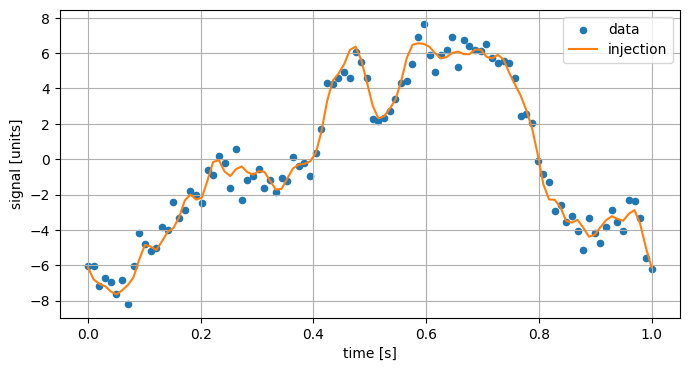

In [250]:
# injected parameters
logamp_inj = 1.2
gamma_inj = 2.7
hypers_inj = jnp.array([logamp_inj, gamma_inj])
sigma_inj = 0.7
rho_inj = fast_get_rho_diag(hypers_inj)
a_inj = jnp.sqrt(rho_inj) * jr.normal(jr.key(112), (Na,))
x_inj = jnp.concatenate((hypers_inj, jnp.array([sigma_inj]), a_inj))
ndim = x_inj.shape[0]

# simulate data
noise = jr.normal(jr.key(225), (Nt,)) * sigma_inj
signal_inj = F @ a_inj
data = signal_inj + noise
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', label='data', s=20)
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.grid()
plt.show()

## Prior, likelihood, and posterior formulation

In [251]:
# parameter bounds
hyper_mins = jnp.array([-2., 1.])
hyper_maxs = jnp.array([5., 7.])
sigma_min = 0.1
sigma_max = 10.
a_min = -100.
a_max = 100.
x_mins = jnp.concatenate((hyper_mins, jnp.array([sigma_min]), jnp.array([a_min] * Na)))
x_maxs = jnp.concatenate((hyper_maxs, jnp.array([sigma_max]), jnp.array([a_max] * Na)))

# parameter labels
hyper_labels = np.array([r'$\log_{10}A$', r'$\gamma$'])
sigma_label = r'$\sigma$'
a_labels = np.array([rf'$a_{{{(i + 2) // 2}}}$' if i % 2 == 0 else rf'$b_{{{(i + 2) // 2}}}$'
                     for i in range(Na)])
x_labels = np.concatenate((hyper_labels, np.array([sigma_label]), a_labels))

In [252]:
# uniform prior
def uniform_lnprior(x):
    # check if parameters are in bounds
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.0
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_uniform_lnprior = jit(uniform_lnprior)

In [253]:
# get numerator term in prior
def get_aT_phiinv_a(a, lower_cholesky_phi):
    x = js.linalg.solve_triangular(lower_cholesky_phi, a, lower=True)
    return jnp.inner(x, x)
fast_get_aT_phiinv_a = jit(get_aT_phiinv_a)

# get normalization in prior
def get_lndet_phi(lower_cholesky_phi):
    return 2 * jnp.sum(jnp.log(jnp.diag(lower_cholesky_phi)))
fast_get_lndet_phi = jit(get_lndet_phi)

In [254]:
# prior on Fourier coefficients
def lnprior(x):
    # check if parameters are in bounds
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        # unpack parameters
        hypers = x[:2]
        sigma = x[2]
        a = x[3:]
        # get covariance matrix
        phi_L = jnp.linalg.cholesky(jnp.diag(fast_get_rho_diag(hypers)), upper=False)
        return -0.5 * (fast_get_aT_phiinv_a(a, phi_L) + fast_get_lndet_phi(phi_L))
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_lnprior = jit(lnprior)

In [255]:
# constants for likelihood
N = jnp.eye(Nt)
Ninv = jnp.linalg.inv(N)
U = data.T @ Ninv @ data
V = F.T @ Ninv @ data
W = F.T @ Ninv @ F
# likelihood
def lnlike(x):
    # unpack parameters
    hypers = x[:2]
    sigma = x[2]
    a = x[3:]
    return -0.5 * (U + a.T @ W @ a - 2 * jnp.inner(a, V)) / sigma**2. - Nt * jnp.log(sigma)
fast_lnlike = jit(lnlike)

In [256]:
# posterior
def lnpost(x):
    return fast_lnprior(x) + fast_lnlike(x)
fast_lnpost = jit(lnpost)
vectorized_lnpost = jit(vmap(fast_lnpost))

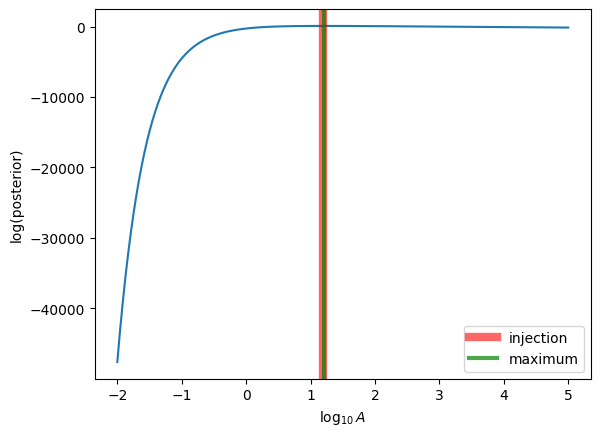

In [257]:
# plot cross-section of posterior
param_ndx = 0
num_evals = 1000
param_vals = jnp.linspace(x_mins[param_ndx], x_maxs[param_ndx], num_evals)
params = jnp.tile(x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

## Sample with HMC

In [258]:
def sampling_model():
    x = jnp.array([numpyro.sample(x_label, Uniform(x_min, x_max))
                   for x_label, x_min, x_max in zip(x_labels, x_mins, x_maxs)])
    numpyro.factor('log_posterior', fast_lnpost(x))

In [260]:
# do HMC with NUTS
num_HMC_samples = int(5e4)
num_warmup = 5000

nuts_kernel = NUTS(sampling_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_HMC_samples)
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
HMC_samples = np.array([samples_dict[x_label] for x_label in x_labels]).T

sample: 100%|██████████| 55000/55000 [02:50<00:00, 323.06it/s, 31 steps of size 1.25e-01. acc. prob=0.93]


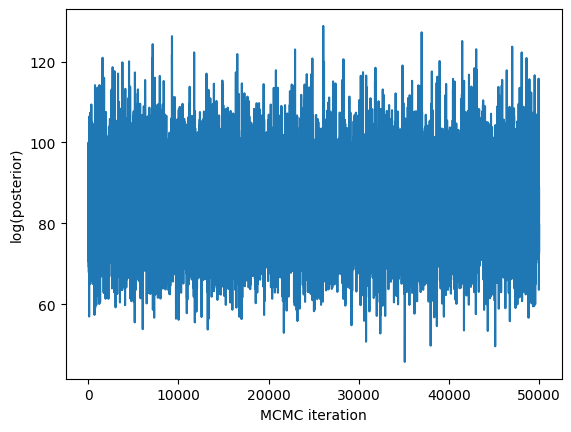

In [261]:
# plot posterior values
HMC_lnposts = vectorized_lnpost(HMC_samples)
plt.plot(HMC_lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.show()

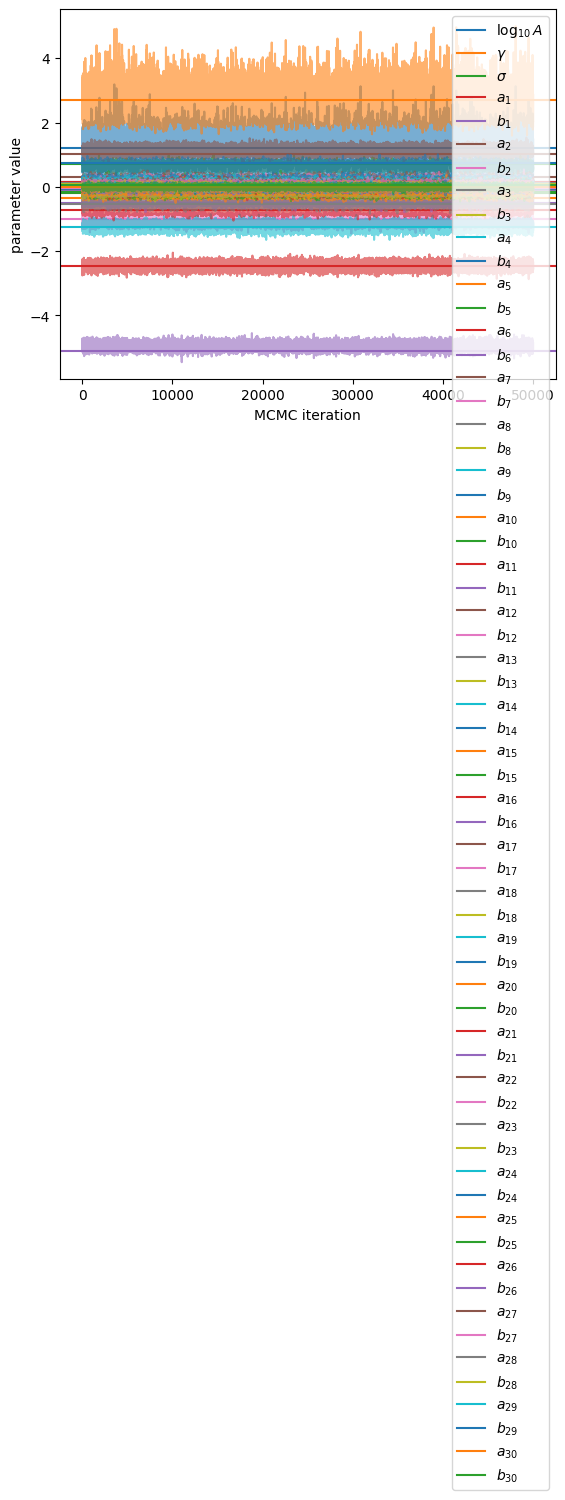

In [262]:
# trace plot
for i in range(ndim):
    plt.plot(HMC_samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(x_inj[i], color=f'C{i}', label=x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

In [264]:
HMC_auto_correlation = int(np.round(integrated_time(HMC_samples[num_HMC_samples//10:])[0]))
HMC_effective_sample_size = HMC_samples.shape[0] // HMC_auto_correlation
print(f'auto-correlation length = {HMC_auto_correlation}')
print(f'effective sample size = {HMC_effective_sample_size}')

auto-correlation length = 1
effective sample size = 50000


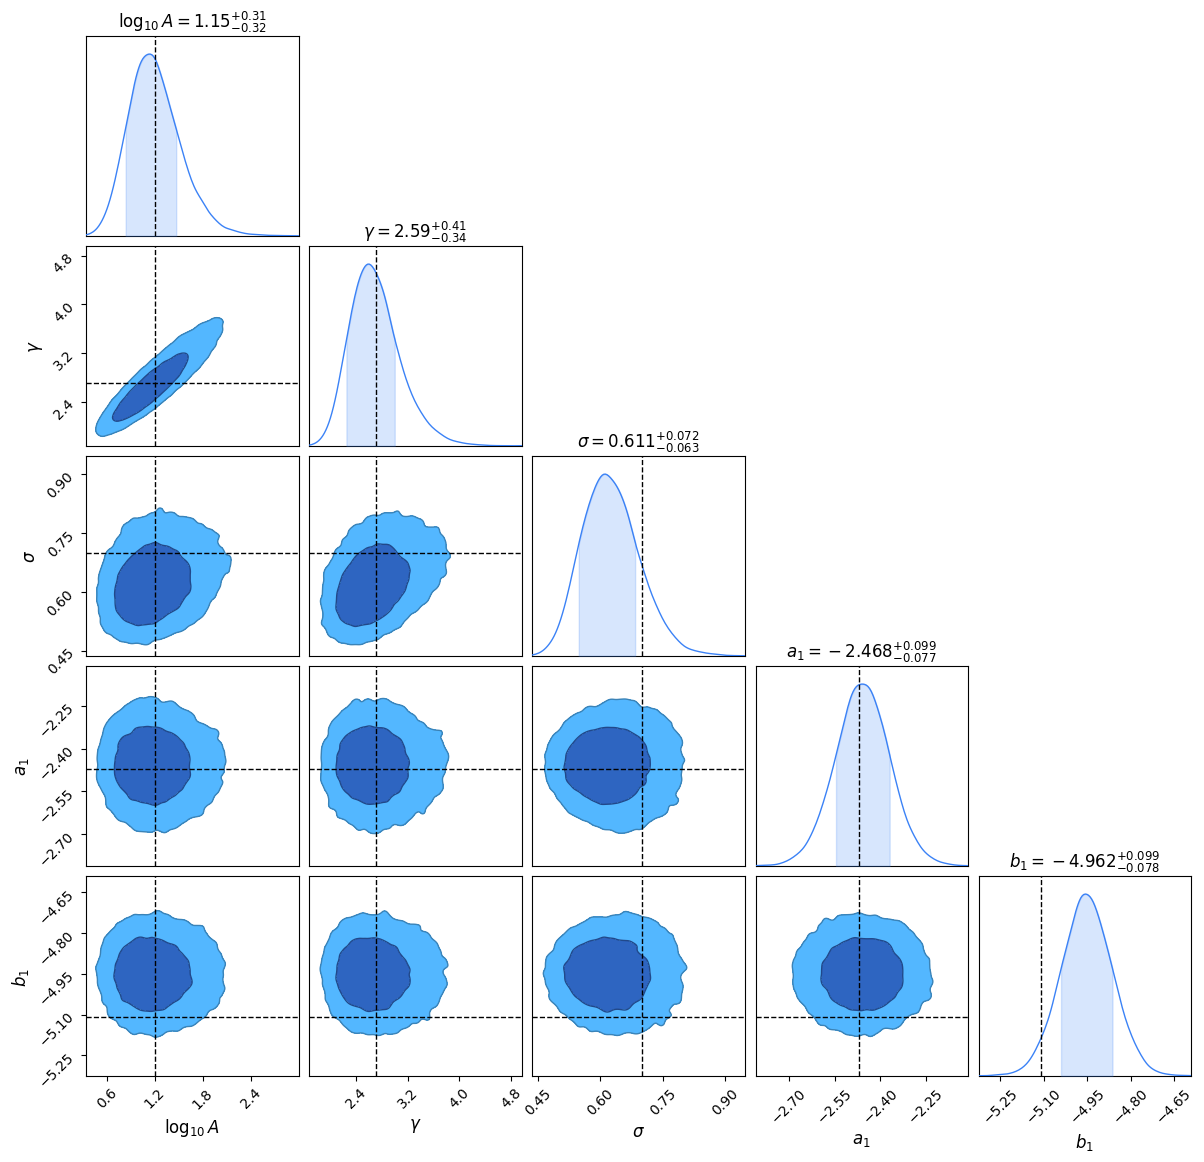

In [292]:
# corner plot
ndxs = np.r_[:5]
burnin = num_HMC_samples // 10
df_hmc = pd.DataFrame(HMC_samples[burnin::HMC_auto_correlation, ndxs], columns=x_labels[ndxs])
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc, name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels[ndxs], x_inj[ndxs])}))
fig = c.plotter.plot()

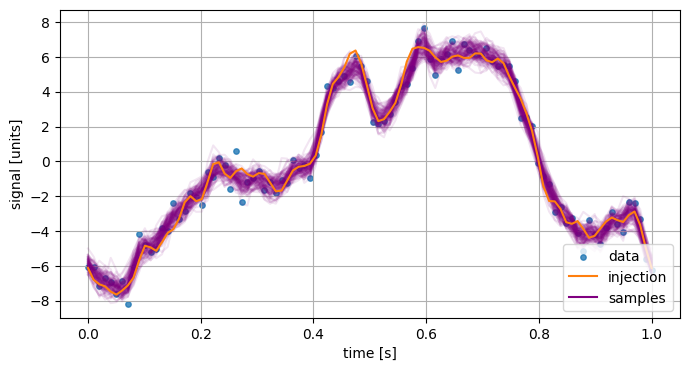

In [266]:
# Bayesogram
num_draws = 100
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', s=15, alpha=0.8, label='data')
_ = [plt.plot(times, F @ samp[3:], color='purple', alpha=10./num_draws)
     for samp in jr.choice(jr.key(0), HMC_samples, (num_draws,))]
plt.plot(times, signal_inj, color='C1', label='injection')
plt.plot([], [], color='purple', label='samples')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Sample with PTMCMC

In [268]:
# wrap posterior for parallel tempering
def pt_lnpost(x, temperature=1.0):
    return fast_lnpost(x) / temperature
fast_pt_lnpost = jit(pt_lnpost)

In [269]:
# do parallel tempering MCMC
num_pt_samples = int(1e5)
num_chains = 10

pt_samples, pt_lnposts, temp_ladder = ptmcmc_sampler(num_samples=num_pt_samples,
                                                     num_chains=num_chains,
                                                     logpdf_func=fast_pt_lnpost,
                                                     x0=x_inj,
                                                     x_mins=x_mins,
                                                     x_maxs=x_maxs,
                                                     Fisher_jump_weight=20,
                                                     DE_jump_weight=20,
                                                     PT_swap_weight=20)

# transpose samples so ordered (num_chains, num_samples,)
pt_samples = np.transpose(pt_samples, (1, 0, 2))
pt_lnposts = np.transpose(pt_lnposts, (1, 0))

jump acceptance rates

Fisher: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

DE: [0.21800001 0.25       0.266      0.30600002 0.34300002 0.38200003
 0.42700002 0.48800004 0.549      0.633     ]

PT swap: [0.69100004 0.64900005 0.6        0.58900005 0.591      0.577
 0.51500005 0.48800004 0.47300002        nan]



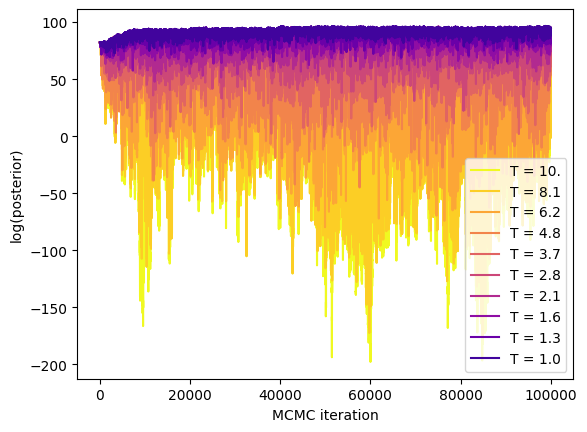

In [270]:
# plot posterior values of chains (without temperature scaling)
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))

for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(pt_lnposts[::-1][j] * temp, color=color, label=f'T = {str(temp)[:3]}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.legend(loc='lower right')
plt.show()

In [271]:
# compute auto-correlation for samples
burnin = num_pt_samples // 10
pt_auto_correlation = int(np.round(integrated_time(pt_samples[0, burnin:])[0]))
pt_effective_sample_size = pt_samples[0, burnin:].shape[0] // pt_auto_correlation
print(f'PT auto-correlation length = {pt_auto_correlation}')
print(f'PT effective sample size = {pt_effective_sample_size}')

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1800;
tau: [2993.54732068]

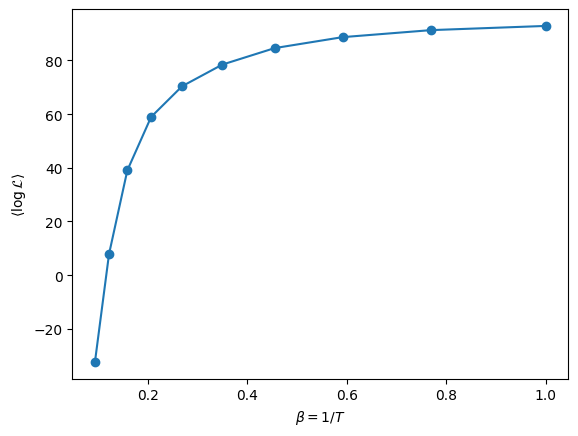

In [272]:
pt_auto_correlation = 1

# average log-likelood over temperatures
burnin = num_pt_samples // 5
avg_lnlikes = np.mean(pt_lnposts[:, burnin::pt_auto_correlation], axis=1) * temp_ladder
betas = 1. / temp_ladder
plt.plot(betas, avg_lnlikes, marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle\log\mathcal{L}\rangle$')
plt.show()

In [294]:
# sample multivariate Gaussian using Fisher
from jax import hessian
Fisher = -hessian(fast_pt_lnpost)(x_inj)
num_Fisher_samples = int(1e5)
Fisher_samples = jr.multivariate_normal(jr.key(1), mean=x_inj, cov=jnp.linalg.inv(Fisher), shape=(num_Fisher_samples,), method='svd')

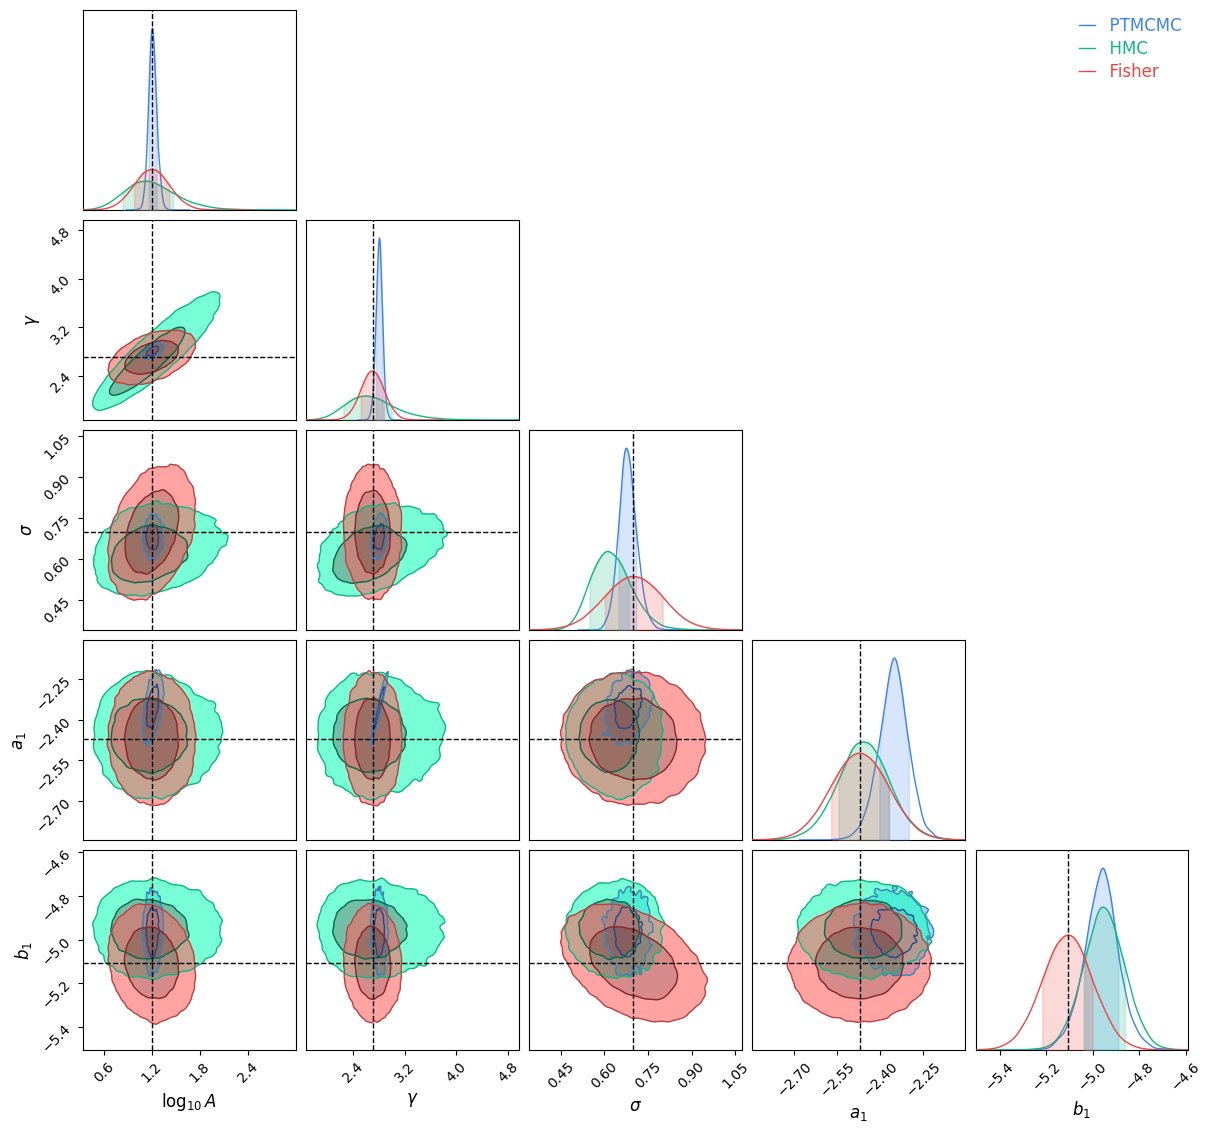

In [295]:
# plot posterior
ndxs = np.r_[:5]
df_pt = pd.DataFrame(pt_samples[0, burnin::pt_auto_correlation, ndxs].T, columns=x_labels[ndxs])
df_Fisher = pd.DataFrame(Fisher_samples[:, ndxs], columns=x_labels[ndxs])
c = ChainConsumer()
c.add_chain(Chain(samples=df_pt, name='PTMCMC'))
c.add_chain(Chain(samples=df_hmc, name='HMC'))
c.add_chain(Chain(samples=df_Fisher, name='Fisher'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels[ndxs], x_inj[ndxs])}))
f = c.plotter.plot()